# 🧭 Introduction

This notebook converts images of waveform traces (e.g., ECG, PPG) into digitized CSV files. 
It:  
- Processes one or more images placed in the input/ folder
- Extracts the pixel coordinates of the waveform trace
- Saves the result to the output/ folder in CSV format (x_pixel, y_pixel)
- We work in pixel space.  
- No time or amplitude calibration is applied in this notebook — this will be handled separately if needed.

# 🛠️ Install and Import Required Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 🗂️ Define Paths and List Input Images



In [2]:

# Set up base folders
base_path = Path.cwd()
input_folder = base_path / "input"
output_folder = base_path / "output"

# Supported image extensions
image_extensions = [".png", ".jpg", ".jpeg"]

# List image files
image_files = [f for f in input_folder.iterdir() if f.suffix.lower() in image_extensions]

print(f"Found {len(image_files)} image(s) for digitization:")
for f in image_files:
    print(" -", f.name)


Found 2 image(s) for digitization:
 - pleth.jpg
 - ecg.png


# 🖼️ Preview the Images

We’ll define a helper function to load and display an image using OpenCV and matplotlib. Images are assumed to be standard 2D waveforms on a white or light background.

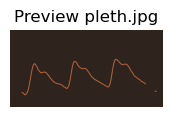

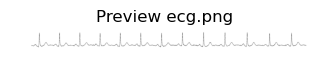

In [ ]:

def preview_image(image_path, figsize=(4, 1)):
    """Display an image with optional figsize (default 4x1)."""
    image = cv2.imread(str(image_path))
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Preview {image_path.name}")
    plt.show()

for image_path in image_files:
    preview_image(image_path)

# ⚙️ Grayscale Conversion and Standardization

Before we can extract waveforms from the images, we need to standardize their format so all downstream processing behaves consistently.  

Real-world images vary in background brightness and trace appearance — some are light with dark traces, others are dark with light traces.  
To make our pipeline robust, we apply the following preprocessing steps:  
	1.	Convert the image to grayscale – color is unnecessary for waveform digitization.  
	2.	Apply a Gaussian blur – this reduces noise and enhances faint or broken traces.  
	3.	Use Otsu’s thresholding – this automatically finds a brightness cutoff that separates foreground (trace) from background.  
	4.	Ensure correct polarity – if the background is not bright enough (i.e., the trace comes out white on black), we invert the result so the trace becomes black and the background white.  
	5.	Enhance the trace with dilation – we use a small morphological kernel to slightly thicken faint traces.  
	6.	Save the standardized binary image to the output/ folder using the original filename with a _std suffix.  
	7.	Preview the result using both small and large preview windows to confirm the trace is now clean and black on a white background.  

The result is a set of black-on-white, binary images with clearly defined waveform traces — ideal for the next step: extracting the shape of the waveform for digitization.

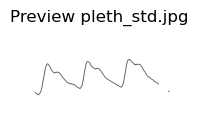

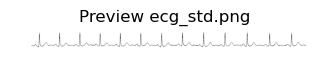

In [61]:
def to_grayscale(image_path):
    """Load and convert an image to grayscale."""
    return cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

def is_bright_background(gray_image, sample_fraction=0.05):
    """Estimate if the image background is bright by sampling the corners."""
    h, w = gray_image.shape
    s = int(min(h, w) * sample_fraction)
    corners = [
        gray_image[0:s, 0:s],
        gray_image[0:s, -s:],
        gray_image[-s:, 0:s],
        gray_image[-s:, -s:]
    ]
    avg = np.mean([np.mean(c) for c in corners])
    return avg > 127

def make_background_white(image):
    """Convert to black trace on white background using blur + Otsu threshold."""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(binary) < 127:
        binary = 255 - binary
    kernel = np.ones((2, 2), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    return binary

def invert_if_dark_background(gray_image):
    """Invert image if background is dark."""
    return gray_image if is_bright_background(gray_image) else 255 - gray_image

# Make a list of the standardized image paths
standardized_paths = []

for image_path in image_files:
    gray = to_grayscale(image_path)
    standardized = make_background_white(gray)

    # Define output filename with _std suffix
    output_path = output_folder / f"{image_path.stem}_std{image_path.suffix}"
    cv2.imwrite(str(output_path), standardized)

    # Add the image paths to a list for later use
    standardized_paths.append(output_path) 

    # Preview both thumbnail and full version
    preview_image(output_path)  # Small
    # preview_image(output_path, figsize=(10, 4))  # Large


# 📉 Extract the Digitized Curve  

In this final stage, we convert our cleaned binary waveform image into two outputs:

1. A **digitised image** showing a smooth, connected version of the trace
2. A **CSV file** containing the full-resolution list of trace pixel coordinates

---

### Why use all black pixels?

Our preprocessing ensured the waveform is:
- Clean and thin (1–2 pixels wide)
- Set against a pure white background
- Without overlaps or double-backs

This makes it safe and desirable to extract **every black pixel** — giving us the most accurate digital version of the waveform, suitable for ML analysis.

---

### What we do in this step:

1. **Extract all black pixels** from the binary image  
   We use `np.where()` to find every (x, y) point where the trace exists.

2. **Sort the pixels left-to-right**  
   Since `np.where()` returns the coordinates in arbitrary order, we sort them by `x` to ensure the trace is rendered as a clean, connected line.

3. **Render the trace**  
   We use OpenCV’s `cv2.polylines()` with anti-aliasing to draw a smooth trace on a blank white image.

4. **Save the digitised trace and CSV**  
   - The image helps us visually inspect the digitisation  
   - The CSV is the key data for downstream ML projects

---

### What’s in the CSV?

Each row in the CSV represents a pixel on the trace:
| x_pixel | y_pixel |
|---------|---------|
| 0       | 156     |
| 1       | 157     |
| ...     | ...     |

This gives a precise digital version of the waveform, without smoothing, compression, or filtering.

The digitised image and CSV are now ready for feature extraction, analysis, or model training.

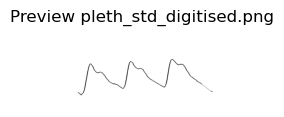

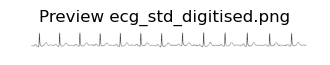

In [62]:
def extract_trace(binary_image):
    """Extract all black trace pixels, sorted left-to-right for drawing."""
    y_pixel, x_pixel = np.where(binary_image == 0)
    sorted_idx = np.argsort(x_pixel)
    return x_pixel[sorted_idx], y_pixel[sorted_idx]

def create_digitised_image(x_pixel, y_pixel, width, height):
    """Draw a clean connected trace from sorted black pixels."""
    img = np.ones((height, width), dtype=np.uint8) * 255
    trace = np.column_stack((x_pixel, y_pixel)).astype(np.int32)
    cv2.polylines(img, [trace], isClosed=False, color=0, thickness=1, lineType=cv2.LINE_AA)
    return img

for std_path in standardized_paths:
    binary_img = cv2.imread(str(std_path), cv2.IMREAD_GRAYSCALE)
    h, w = binary_img.shape

    x_pixel, y_pixel = extract_trace(binary_img)

    # Create and save visual trace
    digitised_img = create_digitised_image(x_pixel, y_pixel, w, h)
    digitised_path = output_folder / f"{std_path.stem}_digitised.png"
    cv2.imwrite(str(digitised_path), digitised_img)
    preview_image(digitised_path)

    # Save full-resolution pixel data
    trace_df = pd.DataFrame({"x_pixel": x_pixel, "y_pixel": y_pixel})
    csv_path = output_folder / f"{std_path.stem}_trace.csv"
    trace_df.to_csv(csv_path, index=False)